# PROJECT: Course Optimization for Data Science
## Optimization strategies for the proportional odds model


Author: Alexandre Gramfort

If you have questions or if something is not clear in the text below please contact us
by email.

## Aim:

- Derive mathematically and implement the loss and gradients of the proportional odds model
- Implement your own solvers for L1 or L2 regularization with: (Accelerated) Proximal gradient descent and L-BFGS (only for L2)
- Implement your own scikit-learn estimator for the proportional odds model and test it on the `wine quality` dataset.

### Remarks:

- This project involves some numerical difficulty due to the presence of many `log` and `exp` functions.
- The correct and stable computation of the gradient is quite difficult. For this reason you have the possibility to use the `autograd` package to compute the gradient by automatic differentiation. `autograd` inspired the design of `pytorch`. It is a pure python package which makes it easy to install, and it is sufficient for our usecase.

## VERY IMPORTANT

This work must be done by pairs of students.
Each student must send their work before the 20th of January at 23:59, using the moodle platform.
This means that **each student in the pair sends the same file**

On the moodle, in the "Optimization for Data Science" course, you have a "devoir" section called "Project".
This is where you submit your jupyter notebook file.

The name of the file must be constructed as in the next cell

### Gentle reminder: no evaluation if you don't respect this EXACTLY

#### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "soufiane"
ln1 = "moutei"
fn2 = "mohammed"
ln2 = "barrahma-tlemcani"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["project", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

project_moutei_soufiane_and_barrahma-tlemcani_mohammed.ipynb


Some imports

In [2]:
%matplotlib inline
import numpy as np
from scipy import linalg
import time
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Part 0: Proportional odds model

This model is an ordinal regression model. It is a supervised learning model, in the case where the target space $Y$ is discrete: $Y=\{1, \dots, k\}$; this is the case in multiclass classification for example. Its specificity is that we assume there is an order in the output space. 

Intuitively, it means that if the true label is 2, predicting 5 is worse that predicting 3 (as 3 is closer to 2 than 5 is). For a usual classification loss, each bad prediction costs the same. In the case of the proportional odds model, **it costs more to predict values that are farther from the true target**.

The proportional odds model can be seen as an extension to the logistic regression model as we will see now.

Working with observations in $\mathbb{R}^p$, the proportional odds model has the following structure for $1 \leq j \leq k-1$:

$$
\log \left ( \frac{P(Y \leq j \mid x)}{P(Y > j \mid x)} \right ) = \alpha_j + \beta^T x ,
$$

where $\beta \in \mathbb{R}^p$ and $\alpha = \{ \alpha_j \}_{j=1}^{k-1}$ is an increasing sequence of constants ($\alpha_1 \leq \alpha_2 \leq \dots \leq \alpha_{k-1}$). We omit here the last term since $P(Y \leq k) = 1$.
Since $P(Y > j | x) = 1 - P(Y \leq j | x)$, we can rewrite the previous equation as:
$$
P(Y \leq j \mid x) = \frac{e^{\alpha_j + \beta^T x}}{e^{\alpha_j + \beta^T x} + 1} = \phi(\alpha_j + \beta^T x)
$$

and 

$$
P(Y = j \mid x) = \frac{e^{\alpha_j + \beta^T x}}{e^{\alpha_j + \beta^T x} + 1} - \frac{e^{\alpha_{j-1} + \beta^T x}}{e^{\alpha_{j-1} + \beta^T x} + 1} = \phi(\alpha_j + \beta^T x) - \phi(\alpha_{j-1} + \beta^T x)
$$

for $2 \leq j \leq k-1$, where $\phi$ denotes the sigmoid function $\phi(t) = 1 / (1 + \exp(-t))$.

After one-hot encoding of the target variable ([`OneHotEncoder`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [`LabelBinarizer`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelBinarizer.html)), denoting $\{ y_{ij} \}_{j=1}^{k}$ the indicator sequence for the class of the $i^{\text{th}}$ observation $x_i$ (i.e., exactly one of the $y_{ij}$ equals one and the rest are zero) the negative log likelihood becomes:

$$
f(\alpha, \beta) =
- \sum_{i=1}^{n} \left [ y_{i1} \log(\phi(\alpha_1 + \beta^T x_i)) 
+ \sum_{j=2}^{k-1} \Big( y_{ij} \log( 
\phi(\alpha_j + \beta^T x_i) - \phi(\alpha_{j-1} + \beta^T x_i)) \Big)
+ y_{ik} \log(1 - \phi(\alpha_{k-1} + \beta^T x_i)) \right ] .
$$

Introducing some $\ell_1$ or $\ell_2$ regularization on the parameter $\beta$ with regularization parameter $\lambda \ge 0$, the penalized likelihood estimation problem reads:
$$
    (\mathcal{P}_\alpha): \left\{
	\begin{aligned}
	\min_{\alpha, \beta} \quad f(\alpha, \beta) + \lambda \mathcal{R}(\beta) \\
    \alpha_1 \leq \dots \leq \alpha_{k-1}
	\end{aligned}
    \right.
$$
where $\mathcal{R}(\beta) = \|\beta\|_1$ or $\tfrac{1}{2} \|\beta\|^2_2$

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
      <li>Justify that $(\mathcal{P}_\alpha)$ is a convex problem.</li>
    </ul>
</div>

A problem is convex if the objective function and the constraints are convex, let's start by the objective function:

We're going to prove the concavity of the two following functions: $\log\phi$ and $\psi \colon t \mapsto \log(1 - e^{t})$ (for $t < 0$). They will help us in proving easily the covexity of $f$.

We have:

$$
(\log\phi)'(t) = (-\log(\frac{1}{\phi}))' = - \frac{-e^{-t}}{1 + e^{-t}} = \frac{1}{1 + e^t}
$$

then:

$$
(\log\phi)''(t) = - \frac{e^t}{(1 + e^t)^2} < 0
$$

Therefore, $\log\phi$ is concave.

On the other hand, we have:

$$
\psi'(t) = - \frac{-e^{t}}{1 - e^{t}} = - \frac{1}{e^{-t} - 1}
$$

then:

$$
\psi''(t) = - \frac{e^{-t}}{(e^{-t} - 1)^2} < 0
$$

Therefore, $\psi$ is concave.

- **The convexity of the objective function**:

Let $1\leq i \leq n$.

For $2 \leq j \leq k-1$, we have: (for $\alpha_{j-1} < \alpha_j$, $\psi (\alpha_{j-1} - \alpha_j)$ is defined. The equality case is not important)

$$
\begin{split}
\log(\phi(\alpha_j + \beta^T x_i) - \phi(\alpha_{j-1} + \beta^T x_i)) & = \log (\frac{1}{1+e^{-(\alpha_j + \beta^T x_i)}} - \frac{1}{1+e^{-(\alpha_{j-1} + \beta^T x_i)}}) \\
& = -(\alpha_j + \beta^T x_i) + \psi (\alpha_{j-1} - \alpha_j) + \log\phi(\alpha_j + \beta^T x_i) + \log\phi (\alpha_{j-1} + \beta^T x_i)
\end{split}
$$

The expression above is a sum of concave functions (because $t \mapsto -t$, $\psi$ and $\log\phi$ are concave and $\alpha_j + \beta^T x_i$ is just an affine transformation)

For $j=1$, the function $\log(\phi(\alpha_1 + \beta^T x_i)) $ is concave since it is just the composition of $\log\phi$ and an affine transformation.

For $j=k-1$, $\log(1 - \phi(\alpha_{k-1} + \beta^T x_i)) = \log(1 - \frac{1}{1+e^{-(\alpha_{k-1} + \beta^T x_i)}}) = -(\alpha_{k-1} + \beta^T x_i) + \psi(\alpha_{k-1}) + \log\phi(\alpha_{k-1} + \beta^T x_i)$ which is the sum of concave functions

We proved that each term is a concave function, and $f$ is containing a minus sign, therefore $f$ is convex.

and $\mathcal{R}$ is convex ($\beta \mapsto \|\beta\|_1$ is convex by the definition of the norm and Jensen's inequality, $\beta \mapsto \tfrac{1}{2} \|\beta\|^2_2$ is convex because its second derivative is equal to $1$)

Hence the convexity of the objective function

- **The convexity of the constraints**:

The constraints are just linear functions ($\alpha \mapsto \alpha_{j} - \alpha_{j-1}$ and $2 \leq j \leq k-1$), so they are convex (the second derivative is zero).

Therefore, $(\mathcal{P}_\alpha)$ is a convex problem

## Simulation

Generate data under the above model and then estimate $\alpha$ and $\beta$ using maximum likelihood

In [3]:
import numpy as np

n = 1000  # number of samples
p = 2  # number of features
k = 3  # number of classes

#### Generate parameters and compute probability distributions for each sample

In [4]:
rng = np.random.RandomState(42)
X = 15 * rng.normal(size=(n, p))
alpha = np.sort(np.linspace(-10, 10, k - 1) + rng.randn(k - 1))
beta = rng.randn(p)

We want to compute the quantity $P(Y = j \mid x_i)$ for $j= 1, \dots , k$, and $i= 1, \dots, n$.

First, let us compute an array containing the values $P(Y < j \mid x_i)$ for $j= 1, \dots , k+1$ and $i=1, \dots, n$. (we denote this array `F`):

In [5]:
def phi(t):
    return 1. / (1. + np.exp(-t))

F = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
F = np.concatenate([np.zeros((n , 1)), F, np.ones((n , 1))], axis=1)
F

array([[0.00000000e+00, 1.19425874e-07, 9.89950079e-01, 1.00000000e+00],
       [0.00000000e+00, 9.22303606e-12, 7.54978894e-03, 1.00000000e+00],
       [0.00000000e+00, 1.10105626e-03, 9.99998900e-01, 1.00000000e+00],
       ...,
       [0.00000000e+00, 2.52740373e-09, 6.75810908e-01, 1.00000000e+00],
       [0.00000000e+00, 1.85838624e-03, 9.99999349e-01, 1.00000000e+00],
       [0.00000000e+00, 4.98712917e-03, 9.99999758e-01, 1.00000000e+00]])

In [6]:
# compute P(Y = j | x)
proba = np.diff(F, axis=1)
assert proba.shape == (n, k)
proba

array([[1.19425874e-07, 9.89949960e-01, 1.00499208e-02],
       [9.22303606e-12, 7.54978894e-03, 9.92450211e-01],
       [1.10105626e-03, 9.98897844e-01, 1.09991567e-06],
       ...,
       [2.52740373e-09, 6.75810905e-01, 3.24189092e-01],
       [1.85838624e-03, 9.98140963e-01, 6.51184001e-07],
       [4.98712917e-03, 9.95012629e-01, 2.41894393e-07]])

The sum of all probas for each sample should be 1:

In [7]:
np.testing.assert_allclose(np.sum(proba, axis=1), np.ones(n))

#### Simulate $Y$ according to $P(Y = j \mid x)$

In [8]:
y = np.array([rng.choice(np.arange(k), size=1, p=pi)[0] for pi in proba])
y[:10]

array([1, 2, 1, 2, 1, 1, 1, 0, 1, 0])

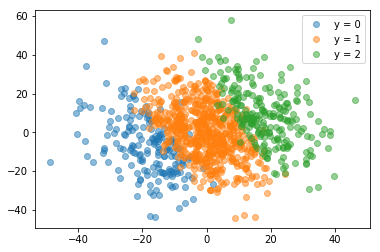

In [9]:
for j in range(k):
    Xj = X[y == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)

plt.legend();

# Log-Likelihood function

We adopt the parametrization from $(\mathcal{P}_\alpha)$. The vector of parameters `params` has `k-1 + p` entries. The first `k-1` are the alphas $\alpha$ and the last `p` entries correspond to $\beta$. The function that predicts the probabilities of each sample reads:

In [10]:
def predict_proba_alphas(params, X=X):
    """Compute the probability of each sample in X.
    
    Parameters:
    -----------
    params: array, shape (k - 1 + p,)
        Parameters of the model. The first k - 1 entries are the alpha_j,
        the remaining p ones are the entries of beta.
        
    X: array, shape (n, p)
        Design matrix.
        
    Returns
    -------
    proba : ndarray, shape (n, k)
        The proba of belonging to each class for each sample.
    """
    n_samples, n_features = X.shape
    n_thresh = params.size - n_features
    alpha = params[:n_thresh]
    beta = params[n_thresh:]
    F = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
    F = np.concatenate(
        [np.zeros((n_samples , 1)), F, np.ones((n_samples , 1))], axis=1)
    proba = np.diff(F, axis=1)
    return proba

One-hot encoding of `y` can be done with scikit-learn `LabelBinarizer`. As it's a matrix, we call it `Y`:

In [11]:
from sklearn import preprocessing

def binarize(y):
    le = preprocessing.LabelBinarizer()
    Y = le.fit_transform(y)
    if Y.shape[1] == 1:
        Y = np.concatenate([1 - Y, Y], axis=1)
    return Y

Y = binarize(y)
Y[:10]

array([[0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [1, 0, 0]])

The negative log-likelihood then reads:

In [12]:
def negloglik_alphas(params, X=X, Y=Y):
    proba = predict_proba_alphas(params, X)
    assert Y.shape == proba.shape
    return -np.sum(np.log(np.sum(proba * Y, axis=1) + np.finfo('float').eps))

params = np.concatenate([alpha, beta])
negloglik_alphas(params)

173.86949983576653

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
      <li>Justify why applying coordinate descent or proximal gradient descent to $(\mathcal{P}_\alpha)$ is not easy (or even possible?).</li>
    </ul>
</div>

- **Coordinate descent**: The constraint $\alpha_1 \leq \dots \leq \alpha_{k-1}$ must be satisfied in each iteration of the coordinate descent algorithm, and we can't guarantee it when we are updating the coordinates independently.

For example if we take the case of $\alpha_{1}$ and $\alpha_{2}$ : 

Let's calculate the derivative of the loss function with respect to $\alpha_1$ : 

We have $\log(\phi(t))' = 1 - \phi(t)$ and $\phi(t)' = \phi(t) (1 - \phi(t))$

then:

$$
\begin{split}
\frac{\partial f}{\partial \alpha_1} & = 
- \sum_{i=1}^{n} \left [ y_{i1} \left(1 - \phi(\alpha_1 + \beta^T x_i) \right) 
- y_{i2} \frac{-\phi(\alpha_1 + \beta^T x_i) (1 - \phi(\alpha_1 + \beta^T x_i))}{\phi(\alpha_2 + \beta^T x_i) - \phi(\alpha_1 + \beta^T x_i)}
\right ] \\
& = - \sum_{i=1}^{n} 
\frac{1 - \phi(\alpha_1 + \beta^T x_i)}{\phi(\alpha_2 + \beta^T x_i) - \phi(\alpha_1 + \beta^T x_i)}
\left [ y_{i1} \left(\phi(\alpha_2 + \beta^T x_i) - \phi(\alpha_1 + \beta^T x_i)) \right) 
+ y_{i2} \phi(\alpha_1 + \beta^T x_i)
\right ]
\end{split}
$$

Since $\phi$ is a strictly increasing function (its derivative $\phi(t)' = \phi(t) (1 - \phi(t)) > 0$), $\phi(\alpha_2 + \beta^T x_i) - \phi(\alpha_1 + \beta^T x_i) > 0$. We have $1 - \phi(\alpha_1 + \beta^T x_i) > 0$, $y_{i1}, y_{i2} > 0$ and $\phi > 0$. 

Hence, $\frac{\partial f}{\partial \alpha_1} < 0$

Given the coordinate descent update step, it is very likely that we reach the case $\alpha_{1} \geq \alpha_{2}$

In this case we can't make progress on $\alpha_{1}$. The same problem will happen if we take $\alpha_{1}$ = $\alpha_{2}$ as initial values.

This case can be generalized for every $\alpha_{j}$ since the update of an $\alpha_{j}$ is made independently, and $\alpha_j$ is tied because of the constraint.

- **Proximal gradient descent**: Here the task is not going to be easy. A constrained proximal gradient descent perfoms a projection after updating the parameters in order to guarentee the constraints. Since all $\alpha_{j}$ are tied with each other, the projection task won't be easy and thus applying *Proximal gradient descent*.

## Reparametrization

To fix the problem, we propose to reparametrize the problem with a new vector $\eta \in \mathbb{R}^{k-1}$ such that $\alpha_j = \sum_{l=1}^{j} \eta_l$ with $\eta_j \geq 0$ for $j \geq 2$.

We denote by $\mathcal{L}(\eta, \beta)$ the corresponding negative log-likelihood:

$$
\mathcal{L}(\eta, \beta) =
- \sum_{i=1}^{n} \left [ y_{i1} \log \left ( \phi(\eta_1 + \beta^T x_i) \right )
+ \sum_{j=2}^{k-1} y_{ij} \log \left ( \phi(\sum_{l=1}^j \eta_l + \beta^T x_i) - \phi(\sum_{l=1}^{j-1} \eta_l + \beta^T x_i) \right ) + y_{ik} \log \left ( 1 - \phi(\sum_{l=1}^{k-1} \eta_l + \beta^T x_i) \right ) \right ] .
$$

<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
      <li>Show that $(\mathcal{P}_\alpha)$ can be rewritten as an unconstrained convex problem $(\mathcal{P}_\eta)$.
$$
    (\mathcal{P}_\eta): \left\{
	\begin{aligned}
	\min_{\eta \in \mathbb{R}^{k-1}, \beta \in \mathbb{R}^{p}} \quad \mathcal{L}(\eta, \beta) + \lambda \mathcal{R}(\beta) + \sum_{j=2}^{k-1} g_j(\eta_j)\\
	\end{aligned}
    \right.
$$
          You will detail what are the functions $g_j$.
    </li>
    <li>
        Justify that the problem can be solved with Proximal Gradient Descent, Proximal Coordinate Descent and the L-BFGS-B algorithm (implemented in scipy.optimize).
    </li>
    </ul>
</div>

- With the proposed reparametrization, the problem $(\mathcal{P}_\alpha)$ is equivalent to:

$$
    (\mathcal{P}_\eta): \left\{
	\begin{aligned}
	\min_{\eta \in \mathbb{R}^{k-1}, \beta \in \mathbb{R}^{p}} \quad \mathcal{L}(\eta, \beta) + \lambda \mathcal{R}(\beta)\\
    \eta_j \geq 0 \ \ , \forall j \geq 2
	\end{aligned}
    \right.
$$

If we take for $j \geq 2$ the characteristic function:

$$
g_j(\eta_j) = \left\{
	\begin{aligned}
	0 \ \text{if} \ \eta_j \geq 0 \\
    +\infty \ \text{if} \ \eta_j < 0
	\end{aligned}
    \right.
$$

We can subtitute the constraints $\eta_j \geq 0$ by adding the functions $g_j$ to the objective function since they impose $\eta_j \geq 0$ implicitly.

In addition, the functions $g_j$ are convex (by applying the Jensen's inequality).

Therefore, we can transform the previous problem to the unconstrained convex problem:

$$
    (\mathcal{P}_\eta): \left\{
	\begin{aligned}
	\min_{\eta \in \mathbb{R}^{k-1}, \beta \in \mathbb{R}^{p}} \quad \mathcal{L}(\eta, \beta) + \lambda \mathcal{R}(\beta) + \sum_{j=2}^{k-1} g_j(\eta_j)\\
	\end{aligned}
    \right.
$$

Hence, $(\mathcal{P}_\alpha)$ can be rewritten as an unconstrained convex problem $(\mathcal{P}_\eta)$

- The problem can be solved with Proximal Gradient Descent, Proximal Coordinate Descent and the L-BFGS-B algorithm. In fact, $(\mathcal{P}_\eta)$ is an unconstrained convex problem. In addition, calculating the proximal operator of $\lambda \mathcal{R}(\beta) + \sum_{j=2}^{k-1} g_j(\eta_j)$ is easy since we can have an explicit form of it as we're going to see in the next question.

<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
      <li>Introducing the functions $f_2(\eta, \beta) = \tfrac{\lambda}{2}\|\beta\|_2^2 + \sum_{j=2}^{k-1} g_j(\eta_j)$ (corresponding to the case where $\mathcal{R}=\tfrac{1}{2}\|\beta\|_2^2$) and $f_1(\eta, \beta) = \lambda \|\beta\|_1 + \sum_{j=2}^{k-1} g_j(\eta_j)$ (corresponding to the case where $\mathcal{R}=\|\beta\|_1$), compute and implement the proximal operators of $f_1$ and $f_2$.
    </li>
    </ul>
</div>

In the code below, `lambda` being a reserved keyword in Python, we denote $\lambda$ by `reg`.

- The proximal operators of $f_1$:

we have $\text{prox}_{f_1} (\eta, \beta) = (\text{prox}_{\sum_{j=2}^{k-1} g_j(\eta_j)} (\eta), \text{prox}_{\lambda \|\beta\|_1} (\beta))$

Since $\text{prox}_{\sum_{j=2}^{k-1} g_j(\eta_j)} (\eta) = (\eta_1, \text{prox}_{g_2} (\eta_2), \dots, \text{prox}_{g_{k-1}}(\eta_{k-1})$ and $\text{prox}_{g_j} (\eta_j) = \text{proj}_{\mathbb{R}^+} (\eta_j) = \max(0, \eta_j) = {\eta_j}_+$ (for $j \geq 2$)

and $\text{prox}_{\lambda \|\beta\|_1} (\beta)) = \text{sign}(\beta) (|\beta| - \lambda)_+$

Therefore:

$$\text{prox}_{f_1} (\eta, \beta) = \left(\eta_1, {\eta_{2:k-1}}_+, \text{sign}(\beta) (|\beta| - \lambda)_+\right)$$

- The proximal operators of $f_2$:

The same as calculating the proximal operator of $f_1$ and since $\text{prox}_{\frac{\lambda}{2} \|\beta\|_2^2} (\beta)) = \frac{\beta}{1 + \lambda}$

Then:

$$\text{prox}_{f_2} (\eta, \beta) = \left(\eta_1, {\eta_{2:k-1}}_+, \frac{\beta}{1 + \lambda}\right)$$

(-1, 3)

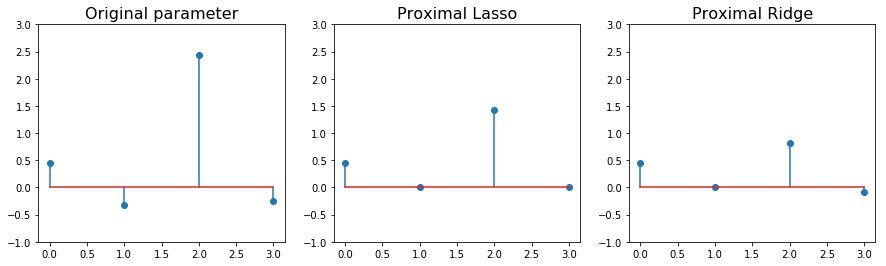

In [13]:
def prox_f2(params, reg=1., n_classes=k):
    # TODO
    eta = params[:n_classes-1]
    beta = params[n_classes-1:]
    
    return np.concatenate([eta[:1], np.maximum(eta[1:], 0), beta/(1. + reg)])
    # END TODO
    #return params

def prox_f1(params, reg=1., n_classes=k):
    # TODO
    eta = params[:n_classes-1]
    beta = params[n_classes-1:]
    
    return np.concatenate([eta[:1], np.maximum(eta[1:], 0), np.sign(beta) * np.maximum(np.abs(beta) - reg, 0)])
    # END TODO
    #return params

rng = np.random.RandomState(5)
x = rng.randn(p + k - 1)
l_l1 = 1.
l_l2 = 2.
ylim = [-1, 3]

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 3, 2)
plt.stem(prox_f1(x, l_l1))
plt.title("Proximal Lasso", fontsize=16)
plt.ylim(ylim)
plt.subplot(1, 3, 3)
plt.stem(prox_f2(x, l_l2))
plt.title("Proximal Ridge", fontsize=16)
plt.ylim(ylim)

## Part 1: Implementation of the solvers

### L-BFGS-B Solver

We will start by using the L-BFGS solver provided by `scipy`, without specifying the gradient function. In this case, the [`fmin_l_bfgs_b`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html) function will approximate the gradient using a finite difference method.

<div class="alert alert-success">
    <b>QUESTION 5:</b>
    <ul>
    <li>
        Implement the new predict_proba function using the new parametrization with $\eta$
    </li>
    </ul>
</div>

In [14]:
def predict_proba(params, X=X):
    """Compute the probability of every sample in X.
    
    Parameters
    ----------
    params : ndarray, shape (k - 1 + p,)
        The parameters. The first k-1 values are the etas
        and the last p ones are beta.
        
    X: array, shape (n, p)
        Design matrix.
    
    Returns
    -------
    proba : ndarray, shape (n, k)
        The proba of belonging to each class for each sample.
    """
    n_samples, n_features = X.shape
    n_thresh = params.size - n_features
    eta = params[:n_thresh]
    beta = params[n_thresh:]
    alpha = eta.cumsum()

    # TODO
    F = phi(np.dot(X, beta)[:, np.newaxis] + alpha)
    F = np.concatenate(
        [np.zeros((n_samples , 1)), F, np.ones((n_samples , 1))], axis=1)
    proba = np.diff(F, axis=1)
    # END TODO
    return proba


def negloglik(params, X=X, Y=Y):
    """Compute the negative log-likelihood.
    
    Parameters
    ----------
    params : ndarray, shape (p + k - 1,)
        The parameters. The first k-1 values are the etas
        and the remaining ones are the entries of beta.
    
    Returns
    -------
    nlk : float
        The negative log-likelihood to be minimized.
    """
    proba = predict_proba(params, X=X)
    assert Y.shape == proba.shape
    return -np.sum(np.log(np.sum(proba * Y, axis=1) + np.finfo('float').eps))

The next cell is to check your implementation:

In [15]:
# Check your implementation
def alpha_to_eta(alpha):
    eta = alpha.copy()
    eta[1:] = np.diff(alpha)
    return eta

# Compute with P_alpha parametrization:
negloglik_alphas(np.concatenate([alpha, beta]))

# Compute with P_eta parametrization:
eta = alpha_to_eta(alpha)
params = np.concatenate([eta, beta])

# Check that log-likelihoods match
assert abs(negloglik(params) - negloglik_alphas(np.concatenate([alpha, beta]))) < 1e-10

<div class="alert alert-success">
    <b>QUESTION 6:</b>
    <ul>
    <li>
        Solve the optimization using the `fmin_l_bfgs_b` function.
    </li>
    </ul>
</div>

HINT: You can specify positivity contraints for certain variables using the `bounds` parameter of `fmin_l_bfgs_b`. Infinity for numpy is `np.inf`.

The estimate of $\beta$ (resp. $\eta$ and $\alpha$) should be called `beta_hat` (resp. `eta_hat` and `alpha_hat`)

In [16]:
from scipy.optimize import fmin_l_bfgs_b
from autograd import grad
import numpy as np

# TODO
x0 = np.zeros(p + k - 1)
x0[:k - 1] = np.arange(k - 1)  # initiatlizing with etas all equal to zero is a bad idea!
bounds = [(None, None)] + [(0, np.inf) for j in range(k-2)] + [(None, None)] * p
params_min, f_min, _ = fmin_l_bfgs_b(
    negloglik, x0, approx_grad=True, 
    bounds=bounds
)
eta_hat = params_min[:k-1]
beta_hat = params_min[k-1:]
alpha_hat = eta_hat.cumsum()
# END TODO

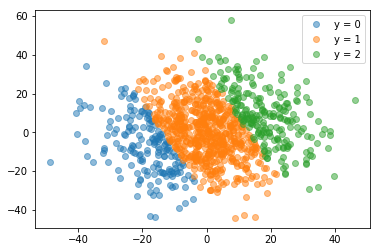

In [17]:
Y_proba = predict_proba(np.concatenate([eta_hat, beta_hat]))
y_pred = np.argmax(Y_proba, axis=1)

for j in range(k):
    Xj = X[y_pred == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)

plt.legend();

### Computation of the gradients

We have so far been lazy by asking `fmin_l_bfgs_b` to approximate the gradient.
You are going to fix this using either one of the next 2 options:

<div class="alert alert-success">
    <b>QUESTION 7 (option 1):</b>
    <ul>
    <li>
        Implement the function grad_negloglik that computes the gradient of negloglik.
    </li>
</ul>
</div>

<div class="alert alert-success">
    <b>QUESTION 7 (option 2):</b>
    <ul>
    <li>
        Implement the function grad_negloglik that computes the gradient of negloglik
        using the <a href="https://github.com/HIPS/autograd">autograd</a> package.
    </li>
    </ul>
</div>

**HINT** : QUESTION 7 (option 1) you can use the fact that: $\log(\phi(t))' = 1 - \phi(t)$ and $\phi(t)' = \phi(t) (1 - \phi(t))$

You can check your implementation of the function `grad_negloglik` with the check_grad function. However **WARNING** your code is likely to be numerically quite unstable due to the numerous `log` and `exp` with tiny values that are probabilities. You may want to work with log of probabilities but **warning** this is not easy...

In [18]:
# Option 1
from scipy.misc import logsumexp

def grad_negloglik(params, X=X, Y=Y):
    # TODO
    
    # END TODO
    return grad


In [19]:
# Option 2

import autograd.numpy as np
from autograd import grad

def negloglik_autograd(params, X=X, Y=Y):
    """Compute the negative log-likelihood

    Parameters
    ----------
    params : ndarray, shape (p + k - 1,)
        The parameters. The first k-1 values are the etas
        and the remaining p ones correspond to beta.
    X : ndarray, shape (n, p)
        Design matrix.
    Y : ndarray, shape (n, k)
        The target after one-hot encoding.

    Returns
    -------
    nlk : float
        The negative log-likelihood to be minimized.
    """
    # TODO
    proba = predict_proba(params, X=X)
    assert Y.shape == proba.shape
    return -np.sum(np.log(np.sum(proba * Y, axis=1) + np.finfo('float').eps))

    # END TODO
    
grad_negloglik = grad(negloglik_autograd)

In [20]:
from scipy.optimize import check_grad
rng = np.random.RandomState(42)
x0 = rng.randn(p + k - 1)
x0[1:k - 1] = np.abs(x0[1:k - 1])
# WARNING: check_grad is likely to return a quite high value
# due to numerical instability with exp and log with tiny
# probability values. Don't be surprised as long as your
# solvers below converge.
check_grad(negloglik_autograd, grad_negloglik, x0=x0)

10567.83908757811

Now plug your gradient into L-BFGS and check the result:

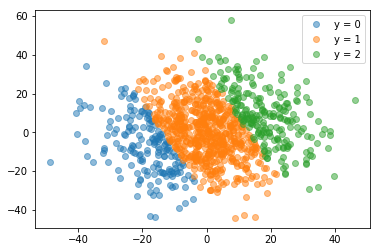

In [21]:
x0 = np.zeros(p + k - 1)
x0[:k - 1] = np.arange(k - 1)  # initiatlizing with etas all equal to zero is a bad idea!
bounds = [(None, None)] + [(0, np.inf) for j in range(k-2)] + [(None, None)] * p
x_hat, _, _ = fmin_l_bfgs_b(negloglik, fprime=grad_negloglik,
                            x0=x0, bounds=bounds)
Y_proba = predict_proba(x_hat)
y_pred = np.argmax(Y_proba, axis=1)

for j in range(k):
    Xj = X[y_pred == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)

plt.legend();

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Wrap this into a function of X, y and lbda that implements
        the function proportional_odds_lbfgs_l2 that will be
        used to get a good value of x_min (minimum of the L2 regularized
        model).
    </li>
    </ul>
</div>

To help you we give you the code of the objective to minimize
in case you use $\ell_1$ or $\ell_2$ penalty.

In [22]:
def pobj_l1(params, X=X, Y=Y, lbda=1.):
    n_features = X.shape[1]
    beta = params[-n_features:]
    n_thresh = Y.shape[1] - 1
    eta = params[:n_thresh]
    if np.any(eta[1:] < 0):
        return np.inf
    return negloglik(params, X=X, Y=Y) + lbda * np.sum(np.abs(beta))

def pobj_l2(params, X=X, Y=Y, lbda=1.):
    n_features = X.shape[1]
    beta = params[-n_features:]
    n_thresh = Y.shape[1] - 1
    eta = params[:n_thresh]
    if np.any(eta[1:] < 0):
        return np.inf
    return negloglik(params, X=X, Y=Y) + lbda / 0.5 * np.dot(beta, beta)

In [23]:
def proportional_odds_lbfgs_l2(X, y, lbda):
    Y = binarize(y)
    n_samples, n_features = X.shape
    n_classes = Y.shape[1]

    # TODO
    pobj_l2_auto = grad(pobj_l2)
    x0 = np.zeros(p + k - 1)
    x0[:k - 1] = np.arange(k - 1)  # initiatlizing with etas all equal to zero is a bad idea!
    bounds = [(None, None)] + [(0, np.inf) for j in range(k-2)] + [(None, None)] * p
    x_min, _, _ = fmin_l_bfgs_b(pobj_l2, fprime=pobj_l2_auto, x0=x0, bounds=bounds)
    # END TODO
    return x_min

x_min = proportional_odds_lbfgs_l2(X, y, lbda=1.)

Check that `x_min` is ok.

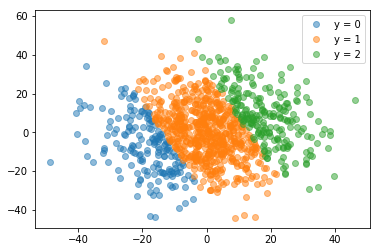

In [24]:
Y_proba = predict_proba(x_min)
y_pred = np.argmax(Y_proba, axis=1)

for j in range(k):
    Xj = X[y_pred == j]
    plt.plot(Xj[:, 0], Xj[:, 1], 'o', label='y = %d' % j, alpha=0.5)

plt.legend();

Now that we have a gradient of the negative loglikelihood term we can implement other solvers. Namely you are going to implement:

- Proximal Gradient Descent (PGD aka ISTA)
- Accelerated Proximal Gradient Descent (APGD aka FISTA)

Before this we are going to define the `monitor` class previously used in the second lab as well as plotting functions useful to monitor convergence.

In [25]:
class monitor(object):
    def __init__(self, algo, obj, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.obj = obj
        self.args = args
        if self.x_min is not None:
            self.f_min = obj(x_min, *args)

    def run(self, *algo_args, **algo_kwargs):
        t0 = time.time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time.time() - t0
        self.x_list = x_list
        if self.x_min is not None:
            self.err = [linalg.norm(x - self.x_min) for x in x_list]
            self.obj = [self.obj(x, *self.args) - self.f_min for x in x_list]
        else:
            self.obj = [self.obj(x, *self.args) for x in x_list]


def plot_epochs(monitors, solvers):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    for monit in monitors:
        ax1.semilogy(monit.obj, lw=2)
        ax1.set_title("Objective")
        ax1.set_xlabel("Epoch")
        ax1.set_ylabel("objective")

    ax1.legend(solvers)

    for monit in monitors:
        if monit.x_min is not None:
            ax2.semilogy(monit.err, lw=2)
            ax2.set_title("Distance to optimum")
            ax2.set_xlabel("Epoch")
            ax2.set_ylabel("$\|x_k - x^*\|_2$")

    ax2.legend(solvers)


def plot_time(monitors, solvers):
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

<div class="alert alert-success">
    <b>QUESTION 8a:</b>
    <ul>
    <li>
        Implement the proximal gradient descent (PGD) method
    </li>
    </ul>
</div>

The parameter `step` is the size of the gradient step.

In [26]:
def pgd(x_init, grad, prox, n_iter=100, step=1., store_every=1,
        grad_args=(), prox_args=()):
    """Proximal gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x = prox(x - step * grad(x, *grad_args), *prox_args) # Update formula
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

<div class="alert alert-success">
    <b>QUESTION 8b:</b>
    <ul>
    <li>
        Using the monitor class and the plot_epochs function, display the convergence.
    </li>
    </ul>
</div>

NOTE: You will have to provide a `step` value, which should be theoretially less than `1 / lipschitz_constant`. You will propose a value for it but you are not expected to provide a mathematical proof, unless you think it's a moral duty to give one...

To help you we give you the proximal operator functions for $\ell_1$ and $\ell_2$ regularized models.

In [27]:
def prox_l1(params, step, lbda, n_classes):
    return prox_f1(params, reg=step * lbda, n_classes=n_classes)

def prox_l2(params, step, lbda, n_classes):
    return prox_f2(params, reg=step * lbda, n_classes=n_classes)

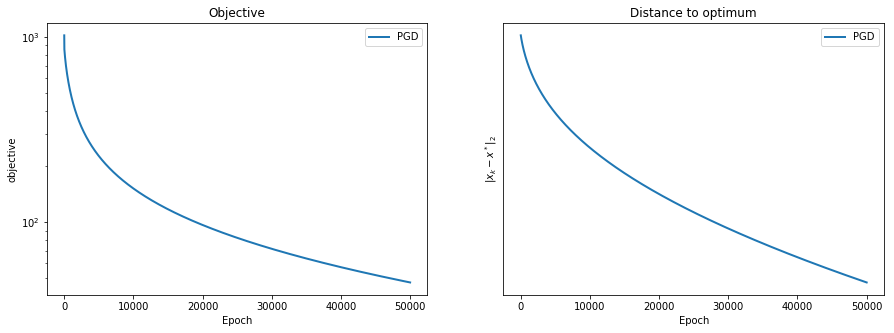

In [28]:
from numpy.linalg import norm

x_init = np.zeros(p + k - 1)
x_init[:k - 1] = np.arange(k - 1)
n_iter = 50000
lbda = .1

# TODO
def lip_logreg(A):
    """Lipschitz constant for logistic loss"""    
    return (norm(A) ** 2) / 4.

step = .5 / lip_logreg(X)
monitor_pgd_l2 = monitor(pgd, pobj_l2, x_min, args=(X, Y, lbda))
monitor_pgd_l2.run(x_init, grad_negloglik, prox_l2, n_iter, step,
                   grad_args=(X, Y), prox_args=(step, lbda, k))
# END TODO

monitors = [monitor_pgd_l2]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

Now for the $\ell_1$ regularization:

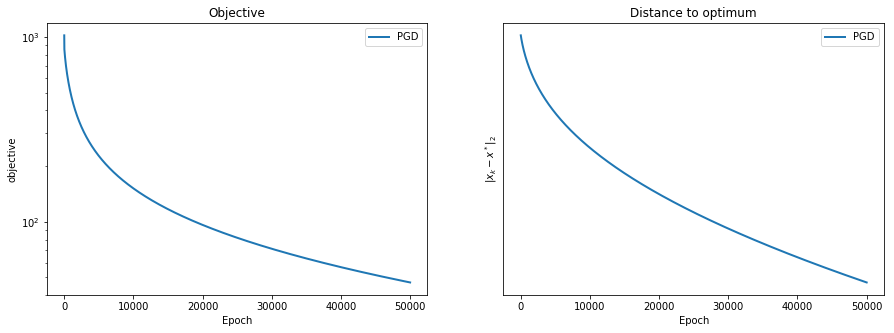

In [29]:
lbda = 1.

# Run PGD for L1
monitor_pgd_l1 = monitor(pgd, pobj_l1, x_min, args=(X, Y, lbda))
monitor_pgd_l1.run(x_init, grad_negloglik, prox_l1, n_iter, step,
                   grad_args=(X, Y), prox_args=(step, lbda, k))

monitors = [monitor_pgd_l1]
solvers = ["PGD"]
plot_epochs(monitors, solvers)

<div class="alert alert-success">
    <b>QUESTION 9:</b>
    <ul>
    <li>
        Implement the accelerated proximal gradient descent (APGD) and add this solver to the monitoring plots.
    </li>
    </ul>
</div>

In [30]:
def apgd(x_init, grad, prox, n_iter=100, step=1., store_every=1,
        grad_args=(), prox_args=()):
    """Accelerated proximal gradient descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = prox(y - step * grad(y, *grad_args), *prox_args)
        t_new = (1. + np.sqrt(1. + 4.*(t ** 2))) / 2.
        y = x_new + ((t - 1.) / t_new) * (x_new - x)
                
        x = x_new.copy()
        t = t_new
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

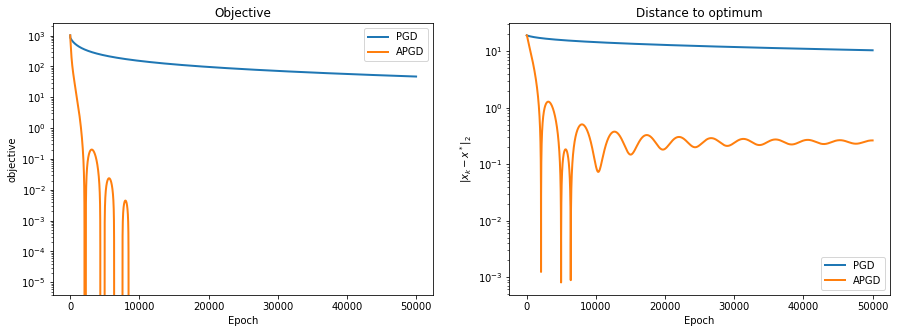

In [31]:
lbda = 0.1

# TODO
monitor_apgd_l2 =  monitor(apgd, pobj_l2, x_min, args=(X, Y, lbda))
monitor_apgd_l2.run(x_init, grad_negloglik, prox_l2, n_iter, step,
                   grad_args=(X, Y), prox_args=(step, lbda, k))
# END TODO

monitors = [monitor_pgd_l2, monitor_apgd_l2]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

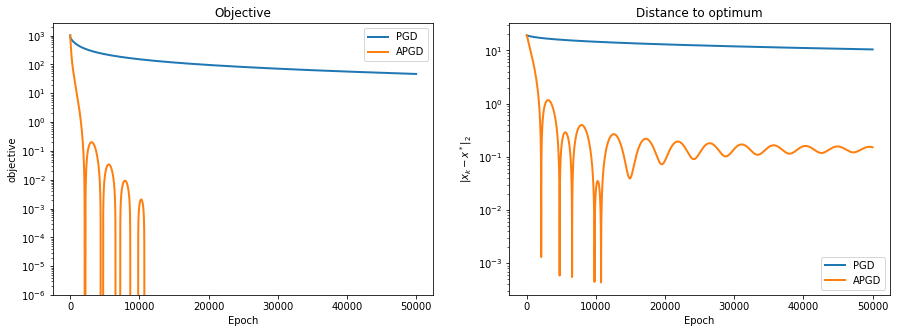

In [32]:
lbda = 1.

# TODO
monitor_apgd_l1 =  monitor(apgd, pobj_l1, x_min, args=(X, Y, lbda))
monitor_apgd_l1.run(x_init, grad_negloglik, prox_l1, n_iter, step,
                   grad_args=(X, Y), prox_args=(step, lbda, k))
# END TODO

monitors = [monitor_pgd_l1, monitor_apgd_l1]
solvers = ["PGD", "APGD"]
plot_epochs(monitors, solvers)

# Part 2: Application

You will now apply your solver to the `wine quality` dataset. Given 11 features
that describe certain wines (our samples), the objective it to predict the quality of the wine,
encoded by integers between 3 and 8. Rather than using a multiclass classification
model we're going to use a proportional odds model.

Let's first inspect the dataset:

In [33]:
import pandas as pd

df = pd.read_csv('winequality-red.csv', delimiter=';')
df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5
1598,6.0,0.310,0.47,3.6,0.067,18.0,42.0,0.99549,3.39,0.66,11.0,6


In [34]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

Now let's extract `X` and `y`

In [35]:
data = df.values
X = data[:, :-1]
y = data[:, -1] - 3
X.shape, y.shape, np.unique(y)

((1599, 11), (1599,), array([0., 1., 2., 3., 4., 5.]))

Let's do a basic scaling of the features:

In [36]:
from sklearn.preprocessing import scale
X = scale(X)

Now test the functions above with this dataset:

In [37]:
x_init = np.zeros(X.shape[1] + np.unique(y).size - 1)
Y = binarize(y)
negloglik(x_init, X=X, Y=Y)
grad_negloglik(x_init, X=X, Y=Y)

array([ 0.00000000e+00, -5.96726951e+16, -7.66737837e+17, -7.18324141e+17,
       -2.24054081e+17,  1.16138509e+00, -1.52163446e+01,  8.11900904e+00,
       -9.23896449e-02, -7.36157019e+00,  9.56606711e-02, -2.84967585e-01,
       -9.22049809e+00, -5.37425526e+00,  8.42355391e+00,  1.63170073e+01])

In order to facilitate our experiment we're going to write a full scikit-learn estimator.

<div class="alert alert-success">
    <b>QUESTION 10:</b>
    <ul>
    <li>
        Implement the `fit` method from the estimator in the next cell
    </li>
    </ul>
</div>

In [38]:
from sklearn.base import BaseEstimator, ClassifierMixin


class ProportionalOdds(BaseEstimator, ClassifierMixin):
    """scikit-learn estimator for the proportional odds model
    
    Parameters
    ----------
    lbda : float
        The regularization parameter
    penalty : 'l1' | 'l2'
        The type of regularization to use.
    max_iter : int
        The number of iterations / epochs to do on the data.
    solver : 'pgd' | 'apgd' | 'lbfgs'
        The type of regularization to use.
        'lbfgs' is only supported with penalty='l2'.
        
    Attributes
    ----------
    alpha_ : ndarray, (n_classes - 1,)
        The alphas.
    beta_ : ndarray, (n_features,)
        The regression coefficients.
    """
    def __init__(self, lbda=1., penalty='l2', max_iter=2000,
                 solver='lbfgs'):
        self.lbda = lbda
        self.penalty = penalty
        self.max_iter = max_iter
        self.solver = solver
        assert self.penalty in ['l1', 'l2']
        assert self.solver in ['pgd', 'apgd', 'lbfgs'] 

    def fit(self, X, y):
        """Fit method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.
        y : ndarray, shape (n_samples,)
            The target. Must be integers between 0 and n_classes - 1.
        """ 
        
        # TODO
        Y = binarize(y)
        
        n_samples, n_features = X.shape
        n_classes = Y.shape[1]
        
        p = n_features  # number of features
        k = n_classes  # number of classes

        step = .5 / lip_logreg(X)
        
        x_init = np.zeros(p + k - 1)
        x_init[:k - 1] = np.arange(k - 1)
        
        if self.penalty == 'l1': 
            pobj = pobj_l1
            prox = prox_l1
        elif self.penalty == 'l2':   
            pobj = pobj_l2
            prox = prox_l2
            
        if self.solver == "lbfgs": 
            pobj_auto = grad(pobj)
            bounds = [(None, None)] + [(0, np.inf) for j in range(k-2)] + [(None, None)] * p
            x, _, _ = fmin_l_bfgs_b(pobj, x_init, fprime=pobj_auto, args=(X, Y, self.lbda), bounds=bounds)
        else:
            solver = pgd if (self.solver == "pgd") else apgd
                
            monitor_ = monitor(solver, pobj, x_min=None, args=(X, Y, self.lbda))
            monitor_.run(x_init, grad_negloglik, prox, self.max_iter, step,
                               grad_args=(X, Y), prox_args=(step, self.lbda, k))
            
            x = monitor_.x_list[-1] 
          
        eta = x[:k-1]
        beta = x[k-1:]
        
        # END TODO
        self.params_ = x
        self.alpha_ = eta.cumsum()
        self.beta_ = beta
        return self

    def predict(self, X):
        """Predict method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_pred : ndarray, shape (n_samples,)
            The predicted target.
        """
        return np.argmax(self.predict_proba(X), axis=1)

    def predict_proba(self, X):
        """Predict proba method
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            The features.

        Returns
        -------
        y_proba : ndarray, shape (n_samples, n_classes)
            The predicted probabilities.
        """
        return predict_proba(self.params_, X)

<div class="alert alert-success">
    <b>QUESTION 11:</b>
    <ul>
    <li>
        Compare the cross-validation performance of your model with a multinomial
        logistic regression model that ignores the order between the classes. You will comment your results.
    </li>
    </ul>
</div>

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# TODO
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial')
print("Multinomial logistic regression:", cross_val_score(clf, X, y, cv=5).mean())  

for lbda, penalty in [(.1, "l2"), (1., "l1")]:
    for solver in ['pgd', 'apgd', 'lbfgs']:
        clf_propodds = ProportionalOdds(lbda=lbda, penalty=penalty, solver=solver, max_iter=1000)
        print("Proportional odds model (penalty=%s, lambda=%f, solver=%s):"%(penalty, lbda, solver), 
              cross_val_score(clf_propodds, X, y, cv=5).mean())  
# END TODO


Multinomial logistic regression: 0.5805591527401468
Proportional odds model (penalty=l2, lambda=0.100000, solver=pgd): 0.5855200638320395
Proportional odds model (penalty=l2, lambda=0.100000, solver=apgd): 0.5836273193525443
Proportional odds model (penalty=l2, lambda=0.100000, solver=lbfgs): 0.5836273193525443
Proportional odds model (penalty=l1, lambda=1.000000, solver=pgd): 0.586141181844462
Proportional odds model (penalty=l1, lambda=1.000000, solver=apgd): 0.5861431167915412
Proportional odds model (penalty=l1, lambda=1.000000, solver=lbfgs): 0.5861431167915412


The response variable is the wine quality, so it is ordered. Taking into consideration the order between the classes is important. The Multinomial logistic regression throws away the ordering information while Proportional odds model preserves it. Hence the outperformance of the latter despite the small score difference. In addition, the difference between scores is small because there aren't many classes, so the impact of the distance is not big.